In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/06h_tftransform.ipynb"
_nb_title = "Avoid training-serving skew using TensorFlow Transform"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Avoid+training-serving+skew+using+TensorFlow+Transform&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F06_preprocessing%2F06h_tftransform.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06h_tftransform.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06h_tftransform.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/06_preprocessing/06h_tftransform.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# TensorFlow Transformを使用して、学習時と推論時のずれを回避する  

このノートブックでは、TF Transformを使用して前処理を効率的に実行する方法を示します。

TF Transformを利用することで、前処理操作をTensorflowグラフとして保存し、推論中に自動的に適用することができます。

## Apache Beamパイプラインをローカルで実行する

実行コマンドは`./run_dataflow.sh`を、実際のapache beamとtftの実装については`./jpeg_to_tfrecord_tft.py`を参照してください。

In [6]:
!cat run_dataflow.sh
!./run_dataflow.sh 
# > /dev/null 2>&1

#!/bin/bash

PROJECT=$(gcloud config get-value project)
BUCKET=${PROJECT}-mlvision   # CHANGE THIS to reflect your bucket

INPUT=gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/all_data.csv
OUTPUT=gs://${BUCKET}/data/flowers_tftransform

## To run locally, uncomment these lines
gsutil cat $INPUT | head -100 > /tmp/top.csv
INPUT=/tmp/top.csv
OUTPUT=./flower_tftransform

# Run
echo "INPUT=$INPUT OUTPUT=$OUTPUT"
python3 -m jpeg_to_tfrecord_tft \
       --all_data $INPUT \
       --labels_file gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dict.txt \
       --project_id $PROJECT \
       --output_dir $OUTPUT \
       --resize '448,448'
INPUT=/tmp/top.csv OUTPUT=./flower_tftransform
Read in 5 labels, from daisy to tulips
Will resize input images to 448x448
2022-08-17 13:41:22.709521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node 

In [7]:
!ls -l flower_tftransform/

total 137476
-rw-r--r-- 1 jupyter jupyter  2954299 Aug 17 13:41 test-00000-of-00002.gz
-rw-r--r-- 1 jupyter jupyter  2598217 Aug 17 13:41 test-00001-of-00002.gz
drwxr-xr-x 4 jupyter jupyter     4096 Aug 17 13:41 tft
drwxr-xr-x 3 jupyter jupyter     4096 Aug 17 13:41 tmp
-rw-r--r-- 1 jupyter jupyter  7333031 Aug 17 13:41 train-00000-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  6654584 Aug 17 13:41 train-00001-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  7235467 Aug 17 13:41 train-00002-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  6811645 Aug 17 13:41 train-00003-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  7061977 Aug 17 13:41 train-00004-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  7936568 Aug 17 13:41 train-00005-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  7291426 Aug 17 13:41 train-00006-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  7954022 Aug 17 13:41 train-00007-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  6274836 Aug 17 13:41 train-00008-of-00016.gz
-rw-r--r-- 1 jupyter jupyter  6928969 Aug 17 13:41 tra

## 前処理されたデータを表示する

Apache BeamとTFTでリスケーリングやリサイジングなどの前処理がされたデータを読み取って表示してみましょう。

In [8]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 448
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

2022-08-17 13:41:54.213981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 13:41:54.214942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 13:41:54.215540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 13:41:54.216558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 13:41:54.217245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

(5, 448, 448, 3)


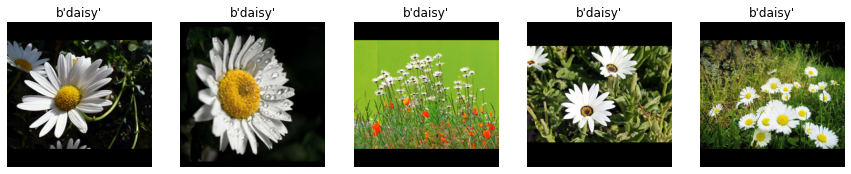

In [9]:
ds = tf.data.experimental.make_batched_features_dataset(
    './flower_tftransform/train-00000-of-00016.gz',
    batch_size=5,
    features = {
        'image': tf.io.FixedLenFeature([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.string),
        'label_int': tf.io.FixedLenFeature([], tf.int64)
    },
    reader=lambda filenames: tf.data.TFRecordDataset(filenames, compression_type='GZIP')
)
for feats in ds.take(1):
    print(feats['image'].shape)

f, ax = plt.subplots(1, 5, figsize=(15,15))
for feats in ds.take(1):
    for idx in range(5): # batchsize
        ax[idx].imshow((feats['image'][idx].numpy()));
        ax[idx].set_title(feats['label'][idx].numpy())
        ax[idx].axis('off')

## モデルの学習

In [10]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [11]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub

def create_preproc_dataset(pattern, batch_size):
    return tf.data.experimental.make_batched_features_dataset(
        pattern,
        batch_size=batch_size,
        features = {
            'image': tf.io.FixedLenFeature([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], tf.float32),
            'label': tf.io.FixedLenFeature([], tf.string),
            'label_int': tf.io.FixedLenFeature([], tf.int64)
        },
        reader=lambda filenames: tf.data.TFRecordDataset(filenames, compression_type='GZIP'),
        num_epochs=1
    ).map(
        lambda x: (x['image'], x['label_int'])
    )

# parameterize to the values in the previous cell
# WARNING! training on a small subset dataset (note top_dir)
def train_and_evaluate(top_dir='./flower_tftransform',
                       batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(os.path.join(top_dir, 'train-*'), batch_size)
    eval_dataset = create_preproc_dataset(os.path.join(top_dir, 'valid-*'), batch_size)

    layers = [
      tf.keras.layers.CenterCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      ),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=3)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/3


2022-08-17 13:42:02.267354: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


3/3 [==============================] - 8s 911ms/step - loss: 1.0783 - accuracy: 0.6220 - val_loss: 0.2157 - val_accuracy: 1.0000
Epoch 2/3
3/3 [==============================] - 1s 172ms/step - loss: 0.2096 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 1s 158ms/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000


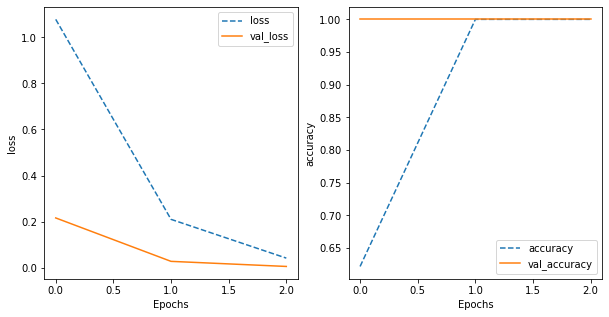

In [12]:
model = train_and_evaluate()

## 推論

TFTが作成した前処理用のTensorflowグラフと、それに続く実際のモデルのグラフを呼び出して推論を実行します。

サービングについては後続の第7章で関数詳しく扱いますが、ここでは、前処理関数を明示的に読み込んで呼び出し、model.predict()を呼び出します。

In [13]:
!saved_model_cli show --dir ./flower_tftransform/tft/transform_fn --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_inputs:0
    inputs['inputs_1'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_inputs_1:0
    inputs['inputs_2'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: serving_default_inputs_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['image'] tensor_info:
        dtype: DT_FLOAT
        sha

In [15]:
# get some files to do inference on.
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
img_bytes = [
    tf.io.read_file(filename) for filename in filenames
]
label = [
    'n/a' for filename in filenames
] # not used in inference
label_int = [
    -1 for filename in filenames
] # not used in inference

data = {
    'label': tf.convert_to_tensor(label, dtype=tf.string),
    'label_int': tf.convert_to_tensor(label_int, dtype=tf.int64),
    'img_bytes': img_bytes
}

# load and call the preproc function and we get images of the right size & crop
tf_transform_output = tft.TFTransformOutput('./flower_tftransform/tft')
preprocessed = tf_transform_output.transform_raw_features(data)

# Call the main model
prediction = model.predict(preprocessed['image'])

# Take the argmx of the result
pred_label_index = tf.math.argmax(prediction).numpy()
print(pred_label_index)

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


[2 1 0 1 4]


## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.